# Train without normalization

This notebook will use the UCI-HAR resampled to 20Hz view (resampled_view_20Hz) and will:

1. Apply DFT over dataset windows
2. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score
3. Plot UMAP and T-SNE

In [1]:
import sys
sys.path.append("../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from librep.datasets.har.loaders import UCIHAR_UnbalancedView20Hz
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.transforms.filter import ButterWorthFilter
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport

2022-10-20 11:30:14.998303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 11:30:14.998322: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Load MotionSense and create PandasMultiModalDatasets with the correct pre-defined windows
loader = UCIHAR_UnbalancedView20Hz("../../../data_2/views/UCI-HAR/unbalanced_20Hz_train_test_9.81_acc_filtered", 
                                   download=False) 
train_val_filtered, test_filtered = loader.load(concat_train_validation=True, label="standard activity code")
train_val_filtered.data['standard activity code'] = train_val_filtered.data['standard activity code'].astype('int')
test_filtered.data['standard activity code'] = test_filtered.data['standard activity code'].astype('int')
train_val_filtered, test_filtered

(PandasMultiModalDataset: samples=2459, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=997, features=360, no. window=6, label_columns='standard activity code')

In [4]:
# Load MotionSense and create PandasMultiModalDatasets with the correct pre-defined windows
loader = UCIHAR_UnbalancedView20Hz("../../../data_2/views/UCI-HAR/unbalanced_20Hz_train_test_9.81_acc", 
                                   download=False) 
train_val_no_gravity, test_no_gravity = loader.load(concat_train_validation=True, label="standard activity code")
train_val_no_gravity.data['standard activity code'] = train_val_no_gravity.data['standard activity code'].astype('int')
test_no_gravity.data['standard activity code'] = test_no_gravity.data['standard activity code'].astype('int')
train_val_no_gravity, test_no_gravity

(PandasMultiModalDataset: samples=2459, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=997, features=360, no. window=6, label_columns='standard activity code')

In [5]:
train_val_filtered.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,user,standard activity code
0,6.961742,10.778332,9.563269,10.229716,9.700441,10.013894,9.604622,9.751559,9.381431,9.394958,...,-0.00046,-0.001029,-0.000238,0.002616,0.006758,0.009952,-0.005709,5,1,1
1,-0.616115,-0.557374,-0.504948,-0.473043,-0.446585,-0.369201,-0.307839,-0.303152,-0.256335,-0.219824,...,-0.005908,-0.010234,-0.011284,-0.009106,-0.001114,-0.001296,-0.002068,5,1,1
2,-0.02363,-0.039409,-0.03171,-0.010933,-0.015305,-0.043188,-0.02402,-0.035,-0.014708,-0.027331,...,0.004503,0.002473,0.001083,0.007256,0.021702,0.007641,0.009008,5,1,1
3,-0.031687,0.006668,0.004699,0.001821,0.048644,-0.026002,0.002109,-0.017645,0.023892,0.012797,...,-0.003793,-0.002657,0.001718,-0.007073,-0.012203,-0.00902,-0.00827,5,1,1
4,0.021979,0.008597,-0.020402,0.016348,0.007953,-0.002194,-0.011266,-0.025485,0.053391,-0.006831,...,-0.001961,0.001915,0.002949,0.007039,-0.004036,-0.00341,-0.004388,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2454,-0.397397,0.501285,0.424851,1.289849,3.975923,5.722475,3.099624,0.228584,-0.514974,-1.428918,...,-0.545852,-0.702665,-0.833772,-0.654115,-0.355501,-0.202928,-0.085239,2,30,3
2455,7.012588,12.555226,13.838454,14.809593,12.072467,9.705683,8.188178,8.218991,5.630945,5.90892,...,-0.579521,-0.84656,-0.700226,-0.574337,-0.199706,0.069693,0.210308,2,30,3
2456,1.979043,4.551149,4.1377,1.323084,-0.782141,-1.030182,-2.094125,-3.574853,-3.627672,-3.732386,...,0.292552,0.203059,-0.17544,0.281563,0.134684,0.21724,0.443779,2,30,3
2457,-2.443248,-3.839537,-2.007886,-2.499533,-2.346011,-1.343588,0.71701,2.77032,7.023206,1.544278,...,0.024815,0.065954,0.06859,0.115724,0.091088,0.309496,0.256306,2,30,3


In [6]:
train_val_no_gravity.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,user,standard activity code
0,0.023421,0.09281,0.051748,0.053044,0.058151,0.062064,0.054399,0.065013,0.067435,0.064698,...,-0.00046,-0.001029,-0.000238,0.002616,0.006758,0.009952,-0.005709,5,1,1
1,-0.006615,-0.005355,0.019899,-0.006828,-0.009687,0.009754,0.041427,-0.009636,0.008558,-0.007307,...,-0.005908,-0.010234,-0.011284,-0.009106,-0.001114,-0.001296,-0.002068,5,1,1
2,-0.006539,-0.019581,-0.011634,0.01158,0.006525,-0.019151,-0.001512,-0.010446,0.007561,-0.003103,...,0.004503,0.002473,0.001083,0.007256,0.021702,0.007641,0.009008,5,1,1
3,-0.037877,0.00988,-0.001231,0.005519,0.042951,-0.021841,-0.003378,-0.013059,0.018568,0.017769,...,-0.003793,-0.002657,0.001718,-0.007073,-0.012203,-0.00902,-0.00827,5,1,1
4,0.013536,0.016908,-0.028985,0.024807,-0.000772,0.006416,-0.020137,-0.016722,0.044381,0.002091,...,-0.001961,0.001915,0.002949,0.007039,-0.004036,-0.00341,-0.004388,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2454,-0.411,0.511663,0.411359,1.300886,3.962514,5.734145,3.086267,0.240866,-0.528328,-1.416055,...,-0.545852,-0.702665,-0.833772,-0.654115,-0.355501,-0.202928,-0.085239,2,30,3
2455,0.050143,1.859659,4.319982,4.634719,2.432258,-0.237494,-1.355517,-1.456428,-3.676076,-3.411408,...,-0.579521,-0.84656,-0.700226,-0.574337,-0.199706,0.069693,0.210308,2,30,3
2456,2.594754,5.116385,4.670734,1.804248,-0.335719,-0.635171,-1.734604,-3.264757,-3.352341,-3.503276,...,0.292552,0.203059,-0.17544,0.281563,0.134684,0.21724,0.443779,2,30,3
2457,-2.431914,-3.81649,-1.993255,-2.473374,-2.329336,-1.315504,0.734617,2.799288,7.040791,1.573255,...,0.024815,0.065954,0.06859,0.115724,0.091088,0.309496,0.256306,2,30,3


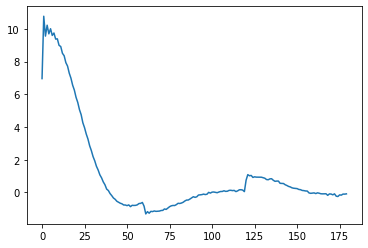

In [26]:
sample = np.array(train_val_filtered.data.iloc[:1,:-183])[0]
plt.plot(sample)

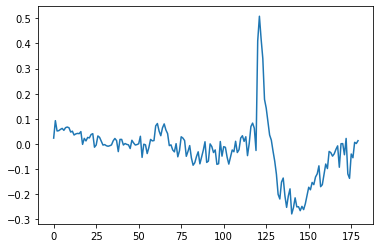

In [27]:
sample = np.array(train_val_no_gravity.data.iloc[:1,:-183])[0]
plt.plot(sample)

In [7]:
data = pd.concat([train_val_filtered.data, train_val_no_gravity.data], axis=0)
# uci2 = train_val_no_gravity.data.iloc[:,:-3]

tam = data.shape[0] // 2
dataset_name = np.array(['UCI_1' for i in range(tam)] + ['UCI_2' for i in range(tam)])
data['DataSet'] = dataset_name

In [8]:
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    data,
    feature_prefixes=features,
    label_columns="DataSet",
    as_array=True
)

In [9]:
# Create the objects
fft_transform = FFT()
# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], new_window_name_prefix="fft."
)

In [10]:
train_fft = transformer(train_dataset)

## Plot UMAP and T-SNE

In [11]:
def plot(df, figsize: tuple = (8, 8), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label, s=1.5)
    ax.legend()
    plt.title(title)
    plt.show()

In [12]:
standard_activity_codes = {
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down"
}
print(standard_activity_codes)

{0: 'sit', 1: 'stand', 2: 'walk', 3: 'stair up', 4: 'stair down', 5: 'run', 6: 'stair up and down'}


In [13]:
dataset = {
    'UCI_1': 'UCI filtered', 
    'UCI_2': 'UCI without gravity'
}
print(dataset)

{'UCI_1': 'UCI filtered', 'UCI_2': 'UCI without gravity'}


### UMAP

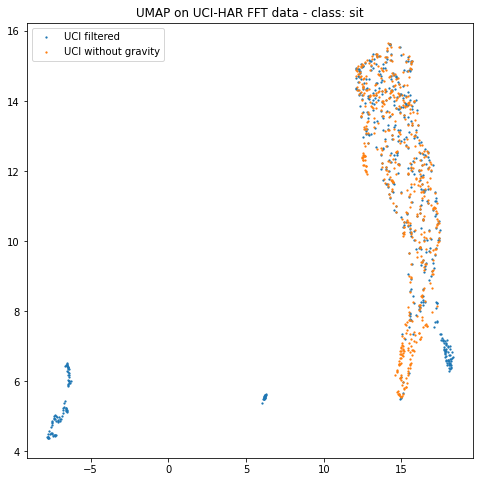

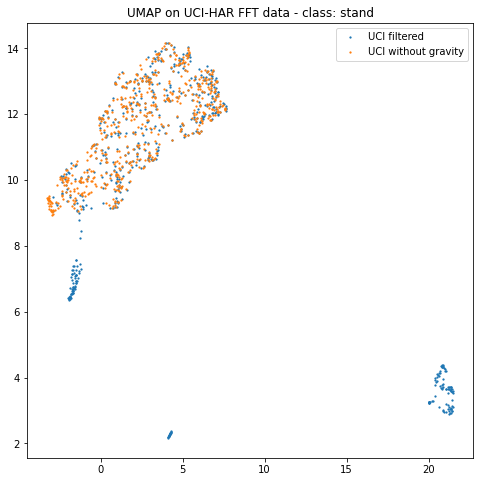

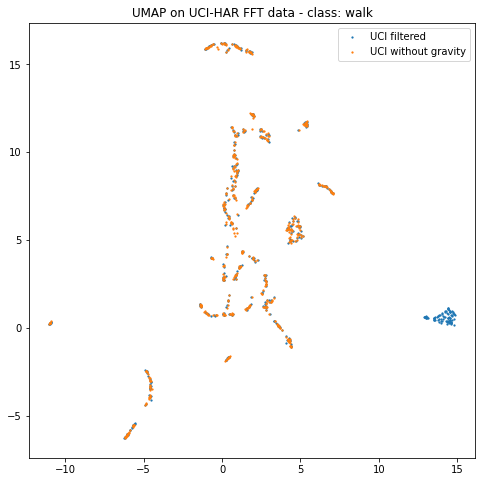

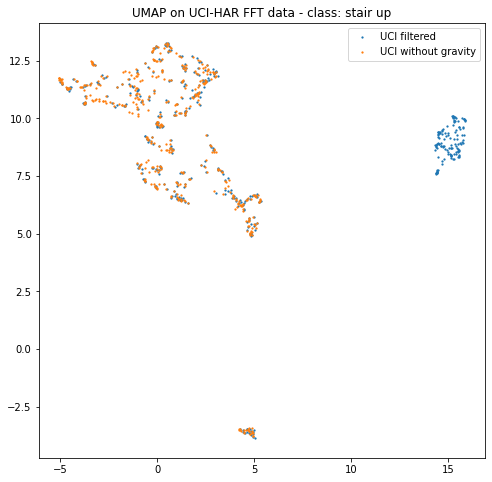

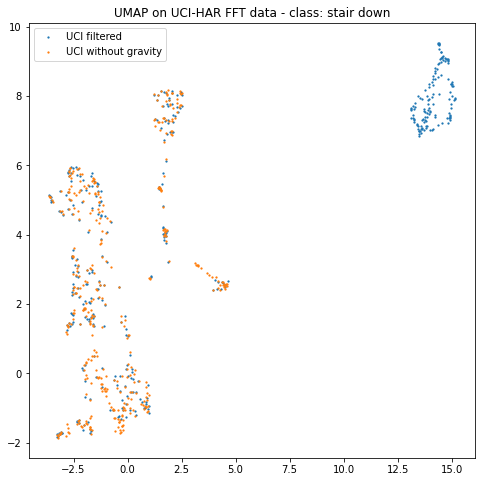

In [58]:
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

lista = []
x = data.groupby('standard activity code')
for y in x:
    lista.append(y)
    
for i in range(len(lista)):
    new_data = lista[i][1]
    features = [
        "accel-x",
        "accel-y",
        "accel-z",
        "gyro-x",
        "gyro-y",
        "gyro-z"
    ]

    # Creating the datasets

    # Train
    train_dataset = PandasMultiModalDataset(
        new_data,
        feature_prefixes=features,
        label_columns="DataSet",
        as_array=True
    )
    new_data_fft = transformer(train_dataset)
    model = UMAP(n_components=2, random_state=0)

    result = pd.DataFrame(model.fit_transform(new_data_fft[:][0]), columns=["x", "y"])
    result["label"] = new_data_fft[:][1]
    classe = lista[i][0]
    plot(result, title="UMAP on UCI-HAR FFT data - class: {}".format(standard_activity_codes[classe]), 
         labels=dataset)

### T-SNE

/home/ic-unicamp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ic-unicamp/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


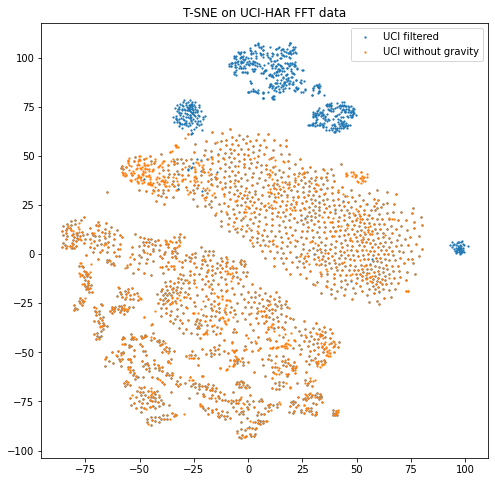

In [15]:
model = TSNE(n_components=2, random_state=0)
result = pd.DataFrame(model.fit_transform(train_fft[:][0]), columns=["x", "y"])
result["label"] = train_fft[:][1]
plot(result, title="T-SNE on UCI-HAR FFT data", labels=dataset)